In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/simple_submission.csv")

C:\Users\Ut Luom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Ut Luom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train.head()

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,...,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,0,1,2019-07-24T03:39:02.854Z,2019-07-31T20:10:02Z,1.0,GH,2018-12-27,2018-12-27,2019-01-01,2019-07-31,...,0.0,0.0,0.0,cb1,1.0,NaN,NaN,NaN,NaN,1
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,1
2,2,0,2019-01-17T07:15:26.367Z,2019-01-17T07:17:45Z,2.0,T1,2019-01-17,2019-01-17,2019-01-01,2019-12-31,...,0.0,0.0,0.0,1,1.0,33.0,10.769445,6.466667,0.0,2
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3


In [4]:
df_test.head()

,id,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,...,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,53030,2019-10-14T01:37:41.959Z,2019-10-14T01:37:41.959Z,2.0,T1,8/27/2019,8/27/2019,9/24/2019,9/23/2020,8/27/2019,...,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,1
1,53031,2019-09-10T09:20:40.066Z,2019-09-11T07:53:44Z,2.0,T1,9/10/2019,9/10/2019,9/14/2019,9/13/2020,9/10/2019,...,0.0,0.0,0.0,notfound,1.0,NaN,NaN,NaN,NaN,1
2,53032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,NaN,1
3,53033,2019-10-21T03:29:30.074Z,2019-10-21T04:17:26Z,2.0,T1,10/21/2019,10/21/2019,11/15/2019,11/14/2020,10/21/2019,...,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1
4,53034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,3,1.0,27.0,NaN,27.0,27.0,1


In [5]:
index = df_test['id']

In [6]:
print(df_train.shape)
print(df_test.shape)

(53030, 195)
(20381, 194)


1. Có 195 columns
2. Mục đích là biến: label
3. Drop Id nhưng lúc sau ta cần cho quá trình submit
4. Giá trị còn thiếu rất nhiều
<h3>.........Chúng ta có 193 feature </h3>

In [7]:
c_train = df_train.copy()
c_test  = df_test.copy()

In [8]:
c_train['train'] = 1
c_test['train'] = 0
df = pd.concat([c_train, c_test], axis=0, sort=False)

### 1. Kiểm tra độ Missing values

In [9]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

Những feature có độ missing lớn hơn 50% giá trị bị thiếu

In [10]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
36,Field_35,87.455558
13,Field_12,86.484314
12,Field_11,86.414842
19,Field_18,84.462819
74,maCv,83.133318
...,...,...
2,Field_1,52.835406
111,E_endDate,52.147498
110,E_startDate,52.147498
109,E_numQuery,52.147498


Tạm thời cứ để nguyên vậy đợi sau khi group and select thì ta sẽ drop sau

### 2.Processing Columns

#### 2.1 Nhóm I:

In [11]:
#xử lí date và dateTime
Date = ['Field_{}'.format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 33, 34, 35, 40]]
DateTime = ['Field_{}'.format(i) for i in [1, 2, 43, 44]]
df[Date + DateTime + ['Field_34']].sample(10)

,Field_5,Field_6,Field_7,Field_8,Field_9,Field_11,Field_15,Field_25,Field_33,Field_34,Field_35,Field_40,Field_1,Field_2,Field_43,Field_44,Field_34
12739,2019-06-22,2019-06-22,2019-06-01,2019-08-31,2019-06-22,2019-08-31,2019-06-28,2019-06-22,2023-01-01,20190603,2019-08-31,2019-06-01,2019-08-23T09:06:01.523Z,2019-08-31T20:11:02Z,2017-02-12T03:34:24.977Z,2019-07-03T03:27:21Z,20190603
44344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8436,2019-05-27,2019-05-27,2019-05-01,2019-08-31,2019-05-27,2019-08-31,2019-05-28,2019-05-27,2018-10-01,20190502,2019-08-31,2019-05-01,2019-08-20T08:47:46.26Z,2019-08-31T20:10:43Z,2019-01-14T02:49:54.293Z,2019-10-01T00:57:32Z,20190502
25354,2018-12-29,2018-12-29,2019-01-01,2019-12-31,2019-01-09,NaN,2019-01-10,2018-12-29,2016-06-01,20180505,NaN,2019-01-01,2019-01-09T14:48:49.438Z,2019-01-10T03:34:45Z,2017-02-05T07:45:31.75Z,2019-06-27T09:48:18.982Z,20180505
24675,2018-12-25,2018-12-25,2019-01-01,2019-12-31,2018-12-25,NaN,NaN,2018-12-25,2020-10-01,20180102,NaN,2019-01-01,2018-12-25T09:07:45.177Z,2019-10-16T06:42:55Z,2017-01-18T10:48:59.34Z,2019-09-19T06:53:54Z,20180102
42854,2019-05-28,2019-05-28,2019-05-01,2019-10-31,2019-05-28,2019-10-31,2019-05-28,2019-05-28,2024-05-01,20190506,2019-10-31,2019-05-01,2019-10-26T08:22:44.455Z,2019-10-31T19:12:11Z,2017-02-10T17:39:12.307Z,2019-10-18T02:26:25.941Z,20190506
9223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15244,3/18/2019,3/18/2019,3/14/2019,3/13/2020,3/18/2019,NaN,3/18/2019,3/18/2019,3/14/2022,20190314,NaN,3/14/2019,2019-03-18T03:27:07.612Z,2019-03-18T03:29:25Z,2017-02-09T10:10:50.867Z,2019-12-24T07:02:16.101Z,20190314
17710,2018-12-24,2018-12-24,2019-01-01,2019-12-31,2018-12-24,NaN,NaN,2018-12-24,2015-01-01,20181105,NaN,2019-01-01,2018-12-24T08:19:20.903Z,2018-12-24T10:25:27Z,2017-03-24T14:37:56.11Z,2019-06-26T10:24:56Z,20181105
22367,2019-04-16,2019-04-16,2019-04-01,2019-06-30,2019-04-16,2019-06-30,2019-04-17,2019-04-16,2024-04-01,20190402,2019-06-30,2019-04-01,2019-06-18T09:43:28.389Z,2019-06-30T20:12:24Z,2017-05-22T08:44:27.331Z,2018-05-15T01:47:39.117Z,20190402


In [12]:
#hàm chung cho field_34 và ngaySinh
def process_field_34(x):
    if x != x:
        return np.nan
    try:
        x = int(x)
    except ValueError:
        x = x.split(' ')[0]
    
    return datetime.strptime(str(x)[:6], "%Y%m")

In [13]:
#xử lí feature date
#hàm chung cho đối tượng datetime(d-m-y)
def process_date(x):
    if x != x:
        return np.nan
    try:
        date_obj = datetime.strptime(x, '%m/%d/%Y')
    except:
        date_obj = datetime.strptime(x, '%Y-%m-%d')
    return date_obj

#xử lí feature datetime
# xử lí datetime có trong df_all mà có dạng T & Z
def process_datetime(x):
    if x != x:
        return np.nan
    x = x.split('.')[0]
    
    if x[-1] == 'Z':
        x = x[:-1]
    date, time = x.split('T')
    datetime_obj = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

In [14]:
# Xử lí nhóm thứ nhất
def process_nhom_I_cols(df):
    cat_cols = []
    for col in Date:
        if col == 'Field_34':
            continue
        df[col] = df[col].apply(process_date) #gọi lại hàm xử lí đối tượng 'date'
        
    for col in DateTime:
        df[col] = df[col].apply(process_datetime) #gọi lại hàm xử lí 'datetime'
 
    df['Field_34'] = df['Field_34'].apply(process_field_34) #gọi lại hàm xử lí 'field_34'
    #df['ngaySinh'] = df['ngaySinh'].apply(process_field_34)
    cat_cols += Date + DateTime
    for col in Date + DateTime:
        df[col] = df[col].dt.strftime('%m-%Y')
    
    # các cọt có ngày tháng năm có trong _startDate và _endDate
    for cat in ['F', 'E', 'C', 'G', 'A']:
        df[f'{cat}_startDate'] = pd.to_datetime(df[f"{cat}_startDate"], infer_datetime_format=True)
        df[f'{cat}_endDate'] = pd.to_datetime(df[f"{cat}_endDate"], infer_datetime_format=True)
        
        df[f'{cat}_startDate'] = df[f'{cat}_startDate'].dt.strftime('%m-%Y')
        df[f'{cat}_endDate'] = df[f'{cat}_endDate'].dt.strftime('%m-%Y')
        
        cat_cols.append(f'{cat}_startDate')
        cat_cols.append(f'{cat}_endDate')
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    return df

#### 2.2 Nhóm II:

In [15]:
# Trong nhóm II có 6 cột thỏa mãn: CJ, CK, CL, CM, CN, CO (số)
# Có nhiều số 0 trong các cột này (dựa vào tableu) gây nhiễu, loại bỏ
def prepare_process_II(df):
    df = str(df).strip().lower()
    df = re.sub(' +', ' ', df)
    return df

def process_II_cols(df):
    for col in ['currentLocationLocationId', 'currentLocationLatitude', 'currentLocationLongitude',
                'homeTownLocationId', 'homeTownLatitude', 'homeTownLongitude']:
        df[col].replace(0, np.nan, inplace=True)
    df['currentLocationLocationId'] = df['currentLocationLocationId'].apply(prepare_process_II).astype('category')
    df['homeTownLocationId'] = df['homeTownLocationId'].apply(prepare_process_II).astype('category')
    return df

#### 2.3 Nhóm III

In [16]:
def prepare_process_III(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def job_category(x):
    if type(x) == str:
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
        or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x\
        or "CN" in x or "CNhân" in x or "Cnhân" in x or "CNV" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return  "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
        else:
            return "missing"
    else:
        return x
    
def process_III_cols(df):
    df["maCv"] = df["maCv"].apply(prepare_process_III).apply(job_category).astype("category")
    return df

#### 2.4 Nhóm IV

In [17]:
#Gộp hai trường này lại để giảm bớt trường hợp thiếu
#hàm kết nối hai feature trên thành lại một feature có tên là "Giới Tính"
def prepare_process_IV(df):
    x, y = df
    if x != x and y != y:
        return 'nan'
    if x != x:
        return y.lower()
    return x.lower()

def process_IV_cols(df):
    df["Giới Tính"] = df[['gioiTinh', 'info_social_sex']].apply(prepare_process_IV, axis=1).astype('category')
    return df

#### 2.5 Nhóm V

In [18]:
def prepare_process_V(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def process_V_cols(df):
    # mã hóa lại các cột sau:
    df['Field_62'] = df['Field_62'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5})
    df['Field_47'] = df['Field_47'].map({'Zezo': 0, 'One': 1, 'Tw0': 2, 'Three': 3, 'Four': 4})
    
    # xử lí các cột có nhiều số 0.0
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
    df["Field_19"] = df["Field_19"].replace({0.0: np.nan})
    df["Field_29"] = df["Field_29"].replace({0.0: np.nan})
    
    # xử lí biến categorical
    df['friendCount'] = df['friendCount'].replace(0.0, np.nan, inplace=True)
    df['subscriberCount'] = df['subscriberCount'].replace(0.0, np.nan, inplace=True)
    
    #xử lí field_38
    df['Field_38'] = df['Field_38'].map({0: 0.0, 1: 1.0, 'DN': np.nan, 'TN': np.nan })
    
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].apply(prepare_process_V).astype('category')
    
    return df

#### 2.6 Drop and transform

In [19]:
drop = ['Field_14', 'Field_16', 'Field_17', 'Field_24', 'Field_26', 'Field_30', 'Field_31', 'Field_37', 'Field_52',
        'Field_57', 'partner0_B', 'partner0_K', 'partner0_L', 'partner1_B', 'partner1_D', 'partner1_E', 'partner1_F',
        'partner1_K', 'partner1_L', 'partner2_B', 'partner2_G', 'partner2_K', 'partner2_L', 'partner3_B', 'partner3_F',
        'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L', 'partner4_A', 'partner4_B', 'partner4_C', 'partner4_D',
        'partner4_E', 'partner4_F', 'partner4_G', 'partner4_H', 'partner4_K', 'partner4_L', 'partner5_B', 'partner5_C',
        'partner5_H', 'partner5_K', 'partner5_L', 'Field_34', 'info_social_sex', 'data.basic_info.locale', 'homeTownCountry',
        'Field_2', 'Field_5', 'Field_49', 'Field_9', 'gioiTinh', 'ngaySinh', 'namSinh', 'Field_10', 'Field_13', 'Field_21', 
        'Field_22', 'Field_38','Field_41', 'Field_42','Field_50', 'Field_53', 'Field_62', 'currentLocationLongitude', 'homeTownLongitude',
        'E_numQuery', 'C_numOrg', 'C_numQuery', 'G_numQuery', 'A_numQuery', 'summary_6m',
        'summary_3m', 'summary_1m', 'summary_1w', 'partner0_C', 'partner0_D', 'partner0_E',
        'partner0_F', 'partner0_H', 'partner1_C', 'partner1_G', 'partner1_H', 'partner2_A',
        'partner2_C', 'partner2_D', 'partner2_E', 'partner2_H', 'partner3_C', 'partner3_E',
        'partner5_D', 'partner5_E', 'partner5_F', 'partner5_G', 'num_of_phone',
        'Field_51', 'Field_73','partner2_F']

def transform(df):
    df = process_nhom_I_cols(df)
    df = process_II_cols(df)
    df = process_III_cols(df)
    df = process_IV_cols(df)
    df = process_V_cols(df)
    return df.drop(drop, 1)

### 3. Transform columns

In [20]:
df = transform(df.copy())

In [21]:
df.head()

,id,label,Field_1,Field_3,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,...,partner3_D,partner5_A,brief,Field_78,Field_79,Field_80,Field_81,Field_82,train,Giới Tính
0,0,1.0,07-2019,1.0,gh,12-2018,01-2019,07-2019,07-2019,g8,...,0.0,0.0,cb1,NaN,NaN,NaN,NaN,1,1,male
1,1,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,0.0,0.0,4,NaN,NaN,NaN,NaN,1,1,nan
2,2,0.0,01-2019,2.0,t1,01-2019,01-2019,12-2019,NaN,nan,...,0.0,1.0,1,33.0,10.769445,6.466667,0.0,2,1,female
3,3,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan
4,4,1.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan


In [22]:
df.shape

(73411, 98)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Data columns (total 98 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         73411 non-null  int64   
 1   label                      53030 non-null  float64 
 2   Field_1                    34624 non-null  category
 3   Field_3                    34624 non-null  float64 
 4   Field_4                    73411 non-null  category
 5   Field_6                    34601 non-null  category
 6   Field_7                    34624 non-null  category
 7   Field_8                    34624 non-null  category
 8   Field_11                   9973 non-null   category
 9   Field_12                   73411 non-null  category
 10  Field_15                   21133 non-null  category
 11  Field_18                   73411 non-null  category
 12  Field_19                   4104 non-null   float64 
 13  Field_20                   3462

### 4.Select the data

In [24]:
object_columns_df = df.select_dtypes(include=['category'])
numerical_columns_df =df.select_dtypes(exclude=['category'])

#### 4.1 Category feature

In [25]:
object_columns_df.dtypes

Field_1                      category
Field_4                      category
Field_6                      category
Field_7                      category
Field_8                      category
Field_11                     category
Field_12                     category
Field_15                     category
Field_18                     category
Field_25                     category
Field_32                     category
Field_33                     category
Field_35                     category
diaChi                       category
Field_36                     category
Field_40                     category
Field_43                     category
Field_44                     category
Field_45                     category
Field_46                     category
Field_48                     category
Field_54                     category
Field_55                     category
Field_56                     category
Field_61                     category
Field_65                     category
Field_66    

In [26]:
object_columns_df.shape

(73411, 52)

In [27]:
object_columns_df.head()

,Field_1,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,Field_15,Field_18,Field_25,...,E_startDate,E_endDate,C_startDate,C_endDate,G_startDate,G_endDate,A_startDate,A_endDate,brief,Giới Tính
0,07-2019,gh,12-2018,01-2019,07-2019,07-2019,g8,NaN,trung tâm kinh doanh tiền mặt,12-2018,...,NaN,NaN,NaN,NaN,NaN,NaN,06-2019,08-2019,cb1,male
1,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,07-2019,07-2019,4,nan
2,01-2019,t1,01-2019,01-2019,12-2019,NaN,nan,01-2019,nan,01-2019,...,08-2019,09-2019,NaN,NaN,NaN,NaN,09-2019,11-2019,1,female
3,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
4,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan


#### 4.2 Numeric feature

In [28]:
numerical_columns_df.dtypes

id                           int64
label                      float64
Field_3                    float64
Field_19                   float64
Field_20                   float64
Field_23                   float64
Field_27                   float64
Field_28                   float64
Field_29                   float64
Field_39                   float64
Field_47                   float64
Field_58                   float64
Field_59                   float64
Field_60                   float64
Field_63                   float64
Field_64                   float64
Field_67                   float64
Field_69                   float64
Field_70                   float64
Field_71                   float64
Field_72                   float64
Field_74                   float64
Field_75                   float64
Field_76                   float64
Field_77                   float64
currentLocationLatitude    float64
homeTownLatitude           float64
topFriends                 float64
numOrg              

In [29]:
numerical_columns_df.shape

(73411, 46)

In [30]:
numerical_columns_df.head()

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1


### 5.Deeling Data

Kiểm tra sự thiếu hụt dữ liệu ở mỗi feature

In [31]:
# Hàm tính tổng các giá trị còn thiếu
def missing_values(df):
    mis_val = df.isnull().sum() #tổng các giá trị còn thiếu
    mis_val_per = 100 * df.isnull().sum()/len(df) #Phần trăm các giá trị còn thiếu
    mis_val_table = pd.concat([mis_val, mis_val_per], axis=1) #Tạo thành bảng để thể hiện 2 giá trị trên
    mis_val_table_rename = mis_val_table.rename(
    columns = {0: "Missing", 1 : "Percent %"})
    #Sắp xếp bảng theo tỉ lệ phần trăm giảm dần
    mis_val_table_rename = mis_val_table_rename[mis_val_table_rename.iloc[:, 1] != 0].sort_values("Percent %", ascending=False).round(1)
    print("Có tất cả " + str(df.shape[1]) + " cột.\n"
          "Trog đó có " + str(mis_val_table_rename.shape[0]) + " cột bị thiếu data")
    return mis_val_table_rename

#### 5.1 Deeling with category feature

In [32]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 52 cột.
Trog đó có 22 cột bị thiếu data


,Missing,Percent %
Field_35,64202,87.5
Field_11,63438,86.4
Field_15,52278,71.2
Field_40,45358,61.8
C_startDate,43699,59.5
C_endDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6


Drop những feature có trên 80% missing

In [33]:
object_columns_df = object_columns_df.drop(columns=['Field_35', 'Field_11', 'Field_15'], axis=1)

In [34]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 49 cột.
Trog đó có 19 cột bị thiếu data


,Missing,Percent %
Field_40,45358,61.8
C_endDate,43699,59.5
C_startDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6
G_startDate,39314,53.6
Field_25,38870,52.9
Field_6,38810,52.9


In [35]:
maCv = object_columns_df['maCv']
maCv

0             NV
1        missing
2        missing
3        missing
4        missing
          ...   
20376    missing
20377    missing
20378    missing
20379    missing
20380         NV
Name: maCv, Length: 73411, dtype: category
Categories (18, object): [BS, CN, CT, CV, ..., YT, missing, ĐB, ĐD]

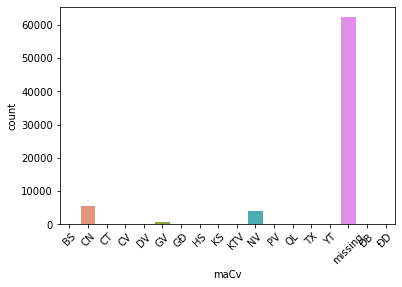

In [36]:
sns.countplot(x='maCv', data=object_columns_df)
plt.xticks(rotation=45)
plt.show()

Tạo ra những cột có giá trị là nằm giữa những giá trị ngày tháng

In [37]:
missing_category = object_columns_df.isnull().sum()
missing_category = ['Field_1', 'Field_6', 'Field_7', 'Field_8', 'Field_25', 'Field_33', 'Field_40', 'Field_43', 'Field_44',
                    'F_startDate', 'F_endDate', 'E_startDate', 'E_endDate', 'C_startDate', 'C_endDate', 'G_startDate',
                    'G_endDate', 'A_startDate', 'A_endDate']

In [38]:
object_columns_df = object_columns_df.drop(missing_category, axis=1)

In [39]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 30 cột.
Trog đó có 0 cột bị thiếu data


,Missing,Percent %


In [40]:
object_columns_df.shape

(73411, 30)

#### 5.2 Deeling with numeric feature

In [41]:
numerical_columns_df.head()

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1


In [42]:
numerical_columns_df.shape

(73411, 46)

In [43]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 46 cột.
Trog đó có 43 cột bị thiếu data


,Missing,Percent %
Field_28,70632,96.2
Field_27,70524,96.1
Field_19,69307,94.4
homeTownLatitude,56029,76.3
currentLocationLatitude,54414,74.1
Field_29,50981,69.4
Field_74,44993,61.3
topFriends,44841,61.1
Field_47,41229,56.2
Field_76,41055,55.9


In [44]:
missing_numeric = ['Field_28', 'Field_27', 'Field_19', 'homeTownLatitude', 'currentLocationLatitude',
                   'Field_29', 'Field_74']

In [45]:
numerical_columns_df = numerical_columns_df.drop(missing_numeric, axis=1)

Fill missng giá trị 0 cho những feature có dưới 30% độ thiếu hụt

In [46]:
numeric_columns_30 = ['label', 'A_numOrg', 'numOrg', 'partner0_A', 'partner0_G', 'partner1_A', 'partner3_A',
                      'partner3_D', 'partner5_A']

In [47]:
numerical_columns_df[numeric_columns_30] = numerical_columns_df[numeric_columns_30].fillna(0)

In [48]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 39 cột.
Trog đó có 27 cột bị thiếu data


,Missing,Percent %
topFriends,44841,61.1
Field_47,41229,56.2
Field_77,41055,55.9
Field_76,41055,55.9
Field_75,41055,55.9
Field_64,40681,55.4
Field_69,39810,54.2
F_numQuery,39602,53.9
F_numOrg,39602,53.9
G_numOrg,39314,53.6


Những columns còn lại fill bằng giá trị median()

In [49]:
def fill_median(df):
    for col in df.columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

In [50]:
numerical_columns_df = fill_median(numerical_columns_df)

In [51]:
numerical_columns_df.head()

,id,label,Field_3,Field_20,Field_23,Field_39,Field_47,Field_58,Field_59,Field_60,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,4258600.0,16.0,1.0,4.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,1,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,2,0.0,2.0,5000000.0,10.0,1.0,0.0,0.0,5.0,3.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


In [52]:
numerical_columns_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          73411 non-null  int64  
 1   label       73411 non-null  float64
 2   Field_3     73411 non-null  float64
 3   Field_20    73411 non-null  float64
 4   Field_23    73411 non-null  float64
 5   Field_39    73411 non-null  float64
 6   Field_47    73411 non-null  float64
 7   Field_58    73411 non-null  float64
 8   Field_59    73411 non-null  float64
 9   Field_60    73411 non-null  float64
 10  Field_63    73411 non-null  float64
 11  Field_64    73411 non-null  float64
 12  Field_67    73411 non-null  float64
 13  Field_69    73411 non-null  float64
 14  Field_70    73411 non-null  float64
 15  Field_71    73411 non-null  float64
 16  Field_72    73411 non-null  float64
 17  Field_75    73411 non-null  float64
 18  Field_76    73411 non-null  float64
 19  Field_77    73411 non-nul

### 6.Encode category

In [53]:
object_columns_df.head()

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,...,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,brief,Giới Tính
0,gh,g8,trung tâm kinh doanh tiền mặt,2018-12-28,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,tf4354f,công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,...,nan,nan,nan,nan,nan,nan,nan,nan,cb1,male
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,4,nan
2,t1,nan,nan,2019-01-17,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,female
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,nan


In [54]:
object_columns_df.dtypes

Field_4                      category
Field_12                     category
Field_18                     category
Field_32                     category
diaChi                       category
Field_36                     category
Field_45                     category
Field_46                     category
Field_48                     category
Field_54                     category
Field_55                     category
Field_56                     category
Field_61                     category
Field_65                     category
Field_66                     category
Field_68                     category
maCv                         category
friendCount                  category
subscriberCount              category
currentLocationLocationId    category
homeTownLocationId           category
currentLocationCity          category
currentLocationCountry       category
currentLocationName          category
currentLocationState         category
homeTownCity                 category
homeTownName

số lượng category trong mõi columns

In [55]:
app = object_columns_df.select_dtypes('category').apply(pd.Series.nunique, axis = 0)
app

Field_4                          3
Field_12                         8
Field_18                      8625
Field_32                      2557
diaChi                       27459
Field_36                        35
Field_45                     13360
Field_46                     17778
Field_48                     15570
Field_54                        50
Field_55                       236
Field_56                      1516
Field_61                        37
Field_65                        11
Field_66                         9
Field_68                     14691
maCv                            18
friendCount                      1
subscriberCount                  1
currentLocationLocationId     1439
homeTownLocationId            1580
currentLocationCity           1021
currentLocationCountry          52
currentLocationName           1276
currentLocationState           236
homeTownCity                  1013
homeTownName                  1306
homeTownState                  170
brief               

In [56]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in object_columns_df:
    if object_columns_df[col].dtype == 'category':
        # If 2 or fewer unique categories
        if len(list(object_columns_df[col].unique())) <= 27459:
            # Train on the training data
            le.fit(object_columns_df[col])
            # Transform both training and testing data
            object_columns_df[col] = le.transform(object_columns_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

30 columns were label encoded.


In [57]:
object_columns_df.describe()

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,...,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,brief,Giới Tính
count,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,...,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000
mean,1.038032,6.586411,6200.088311,2045.906622,14011.570296,15.961790,5415.178897,11290.517947,7673.667938,34.463228,...,1368.483456,541.119519,35.325442,663.171541,132.778371,512.190516,639.236599,90.634837,4.976502,1.038605
std,0.685716,1.062049,1313.737614,701.092131,5395.952369,6.600774,3100.024084,4176.899024,2905.827780,8.025056,...,428.465308,137.733521,9.202854,173.935337,36.390122,137.444766,176.068163,23.462914,6.618145,0.780454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.000000,6559.000000,1647.000000,14038.000000,8.000000,4477.000000,9165.500000,7897.000000,30.000000,...,1579.000000,574.000000,30.000000,660.000000,142.000000,530.000000,638.000000,93.000000,1.000000,0.000000
50%,1.000000,7.000000,6559.000000,2556.000000,14038.000000,21.000000,4477.000000,13451.000000,7897.000000,30.000000,...,1579.000000,574.000000,30.000000,660.000000,142.000000,530.000000,638.000000,93.000000,3.000000,1.000000
75%,2.000000,7.000000,6559.000000,2556.000000,14038.000000,21.000000,5673.000000,13451.000000,7897.000000,48.000000,...,1579.000000,574.000000,51.000000,660.000000,142.000000,530.000000,638.000000,93.000000,5.000000,2.000000
max,2.000000,7.000000,8624.000000,2556.000000,27458.000000,34.000000,13359.000000,17777.000000,15569.000000,49.000000,...,1579.000000,1020.000000,51.000000,1275.000000,235.000000,1012.000000,1305.000000,169.000000,20.000000,2.000000


### 7. Model

In [58]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [59]:
kfold = StratifiedKFold(n_splits=10)

In [60]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,4,7850,1641,4009,8,8219,10752,12700,48,...,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,1,7,6559,2556,14038,21,4477,13451,7897,30,...,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,2,7,6559,1661,18343,8,6738,1183,12827,30,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,1,7,6559,2556,14038,21,4477,13451,7897,30,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,1,7,6559,2556,14038,21,4477,13451,7897,30,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


In [61]:
df_final['id']

0            0
1            1
2            2
3            3
4            4
         ...  
20376    73406
20377    73407
20378    73408
20379    73409
20380    73410
Name: id, Length: 73411, dtype: int64

In [62]:
df_final = df_final.drop(['id',],axis=1)

In [63]:

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [64]:
import numpy as np # linear algebra
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import re 
from IPython.display import display_html
import itertools
import math
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import *
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

#Learning curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve


In [65]:
print('TRAINING')
print(df_train.info())
print('\n\nTEST')
print(df_test.info())

df_train.head(0)
df_test.head(0)

cnt = 0
d_type = ['float64', 'int64','object','dtype']
print('\n\tTRAIN \t\t TEST')

TRAINING
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53030 entries, 0 to 53029
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Field_4                    53030 non-null  int32  
 1   Field_12                   53030 non-null  int32  
 2   Field_18                   53030 non-null  int32  
 3   Field_32                   53030 non-null  int32  
 4   diaChi                     53030 non-null  int32  
 5   Field_36                   53030 non-null  int32  
 6   Field_45                   53030 non-null  int32  
 7   Field_46                   53030 non-null  int32  
 8   Field_48                   53030 non-null  int32  
 9   Field_54                   53030 non-null  int32  
 10  Field_55                   53030 non-null  int32  
 11  Field_56                   53030 non-null  int32  
 12  Field_61                   53030 non-null  int32  
 13  Field_65                   53030 non-

In [66]:
X_train = df_train.drop(['label'], axis=1)
X_test = df_test
y_train = df_train['label']

In [67]:
y_train

0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
53025    0.0
53026    0.0
53027    0.0
53028    0.0
53029    0.0
Name: label, Length: 53030, dtype: float64

In [68]:
# grid search
def GridSearchModel(X, Y, model, parameters, cv):
    CV_model = GridSearchCV(estimator = model, param_grid = parameters, cv = cv)
    CV_model.fit(X, Y)
    CV_model.cv_results_
    print("Best Score:", CV_model.best_score_," / Best parameters:", CV_model.best_params_)

def Confuse(y, y_pred, classes):
    cnf_matrix = confusion_matrix(y, y_pred)
    
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    c_train = pd.DataFrame(cnf_matrix, index = classes, columns = classes)  

    ax = sns.heatmap(c_train, annot = True, square = True, cbar = False, 
                          fmt = '.2f', annot_kws = {"size": 20})
    return(ax, c_train)

# Learning curve
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = 4, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    ax1 = Confuse(y, y_pred, classes)
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std )

def ApplyModel(X, y, model):
    
    model.fit(X, y)
    y_pred  = model.predict(X)

    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
 
    Error   = 1 - Accuracy
    
    precision = precision_score(y_train, y_pred) * 100
    recall = recall_score(y_train, y_pred) * 100
    f1score = f1_score(y_train, y_pred) * 100
    
    return (model, y_pred, Accuracy, Error, precision, recall, f1score)  
    

def PrintResults(model, X, y, title):
    
    model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    _, Score_mean, Score_std = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    print("Precision: %.2f %%"%(precision))
    print("Recall: %.2f %%"%(recall))
    print('f1-score: %.2f %%'%(f1score))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std, 
                       'Precision': precision, 
                       'Recall': recall, 
                       'F1-Score': f1score}, index = [0])
    return (model, Summary)

In [69]:
classes = ["ChoVay", "KhongChoVay"]
cv = ShuffleSplit(n_splits = 100, test_size = 0.25, random_state = 0)
train_size = np.linspace(.1, 1.0, 15)

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Scoring Accuracy: 68.00 %
Scoring Mean: 68.22 %
Scoring Standard Deviation: 0.2970 %
Precision: 36.69 %
Recall: 0.30 %
f1-score: 0.60 %


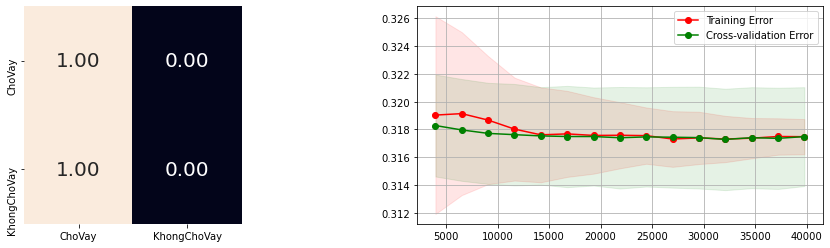

In [70]:
#Logistic Regresion
model = LogisticRegression()
model, Summary_LR = PrintResults(model, X_train, y_train, 'Logistic Regression')

y_train_LR = pd.Series(model.predict(X_train), name = "LR")
y_test_LR = pd.Series(model.predict(X_test), name = "LR")

Scoring Accuracy: 70.00 %
Scoring Mean: 95.59 %
Scoring Standard Deviation: 0.1346 %
Precision: 96.56 %
Recall: 86.62 %
f1-score: 91.32 %


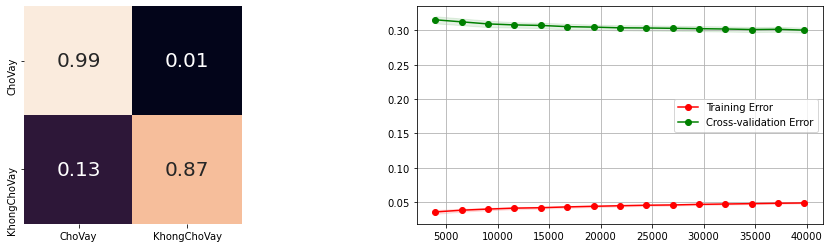

In [71]:
# Random Forest
model = RandomForestClassifier(n_estimators = 10)
model,Summary_RF = PrintResults(model, X_train,y_train, 'Random Forest')
y_train_RF = pd.Series(model.predict(X_train), name = "RF")
y_test_RF = pd.Series(model.predict(X_test), name = "RF")

<h3>Đầu tiên là sẽ sử dụng RandomForest</h3>

In [72]:
# Random Forest
model = RandomForestClassifier(n_estimators = 10, oob_score = True)
model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X_train, y_train, model)
Priority = pd.DataFrame({'Feature': X_train.columns,'Importance':np.round(model.feature_importances_,3)})
Priority  = Priority .sort_values('Importance',ascending = False).set_index('Feature')

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Ut Luom\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. T

In [73]:
Priority.head(15)

,Importance
Feature,
brief,0.070
Field_80,0.069
Field_78,0.062
Field_79,0.060
Field_82,0.054
Field_81,0.043
numOrg,0.038
A_numOrg,0.034
diaChi,0.020


In [74]:
model = RandomForestClassifier(n_estimators = 2, oob_score = True)
_, Summary_RF = PrintResults(model, X_train,y_train,'Random Forest')
y_test_RF = pd.Series(model.predict(X_test), name = 'label')
print("oob score:", round(model.oob_score_, 4) * 100, "%")

KeyboardInterrupt: 

In [75]:
model_rf_final = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'entropy',
            max_depth = 10, max_features = 'log2', max_leaf_nodes = None,
            min_impurity_decrease = 0.0, min_impurity_split = None,
            min_samples_leaf = 1, min_samples_split = 30,
            min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = 1,
            oob_score = False, random_state = None, verbose = 0, warm_start = False)

Scoring Accuracy: 71.00 %
Scoring Mean: 73.11 %
Scoring Standard Deviation: 0.3198 %
Precision: 79.36 %
Recall: 17.17 %
f1-score: 28.23 %


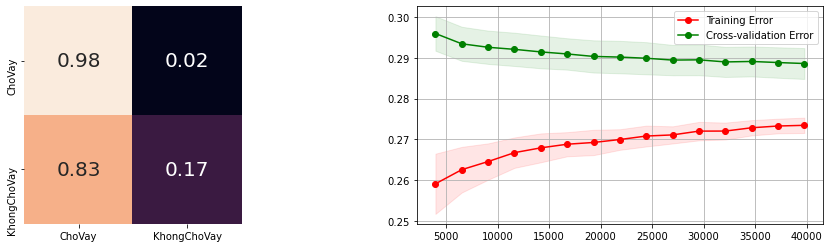

In [76]:
_, Summary_LR = PrintResults(model_rf_final, X_train, y_train, 'Logistic Regression')
y_train_pred = pd.Series(model_rf_final.predict(X_train))
y_test_pred = pd.Series(model_rf_final.predict(X_test))

In [77]:
y_test_pred = pd.Series(model_rf_final.predict(X_test), name = "label")

In [78]:
y_test_pred_final = pd.DataFrame(y_test_pred)

In [79]:
y_test_pred_final.head()

,label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [81]:
y_test_pred_final.shape

(20381, 1)

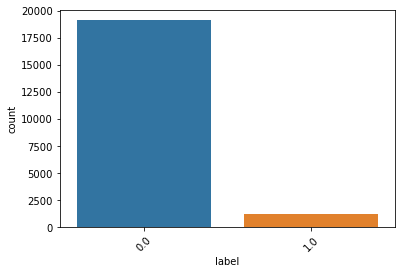

In [84]:
sns.countplot(x='label', data=y_test_pred_final)
plt.xticks(rotation=45)
plt.show()

### 10.Prepare Submission Data

In [83]:
submission = pd.DataFrame({
        "Id": index,
        "label": y_test_pred_final['label']
    })
submission.to_csv('data/Kalapa Submission.csv', index = False)

print('Done')

Done
